In [1]:
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from matplotlib import patches

sns.set()
%matplotlib inline

Say we have some random variable $X$ distributed as

$X \sim Normal(\mu, \Sigma)$

and we put it through a transformation $g$, and end up with

$\tilde{X} = g(x)$

What will the probability distribution of $\tilde{X}$ be?

In [2]:
mu = jnp.zeros(2)
cov = jnp.array([[0.5, 0.2], [0.2, 0.1]])
distribution = dist.MultivariateNormal(mu, cov)
rng_key = jax.random.PRNGKey(2)

In [3]:
def g(x):
    return jnp.asarray([jax.scipy.special.expit(x[0]), jnp.exp(x[1])])

In [4]:
samples = distribution.sample(rng_key, sample_shape=(1000,))
pushforward_samples = jax.vmap(g)(samples)

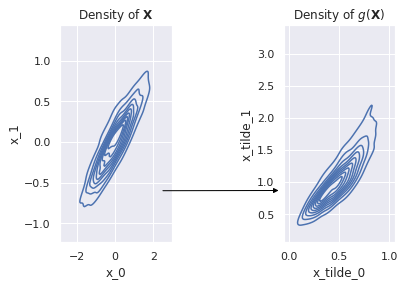

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
axes = axes.flatten()

data = pd.DataFrame(samples, columns=["x_0", "x_1"])
sns.kdeplot(data=data, x="x_0", y="x_1", ax=axes[0])

data = pd.DataFrame(pushforward_samples, columns=["x_tilde_0", "x_tilde_1"])
sns.kdeplot(data=data, x="x_tilde_0", y="x_tilde_1", ax=axes[1])

xyA = [2.5, -0.6]
xyB = [-0.1, .87]
arrow = patches.ConnectionPatch(
    xyA,
    xyB,
    coordsA=axes[0].transData,
    coordsB=axes[1].transData,
    color="black",
    arrowstyle="-|>",
)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1, hspace=None)
axes[0].set_title(r"Density of $\mathbf{X}$")
axes[1].set_title(r"Density of $g(\mathbf{X})$")

fig.patches.append(arrow)
fig.savefig("transformation.png");

In [6]:
def inv_g(x_tilde):
    return jnp.asarray([jax.scipy.special.logit(x_tilde[0]), jnp.log(x_tilde[1])])

In [7]:
x_tilde = jnp.column_stack(
    [jnp.linspace(0.001, 0.999, 1000), jnp.linspace(0.001, 3, 1000)]
)

In [8]:
pre_x_tilde = jax.vmap(inv_g)(x_tilde)

In [9]:
@functools.partial(jax.vmap, in_axes=(0, None))
@functools.partial(jax.vmap, in_axes=(None, 0))
def probability_density(x_0, x_1):
    return jnp.exp(distribution.log_prob(jnp.asarray([x_0, x_1])))

In [10]:
@functools.partial(jax.vmap, in_axes=(0, None))
@functools.partial(jax.vmap, in_axes=(None, 0))
def inv_det_jacobian_g(x_0, x_1):
    return 1 / jnp.linalg.det(jax.jacobian(g)(jnp.asarray([x_0, x_1])))

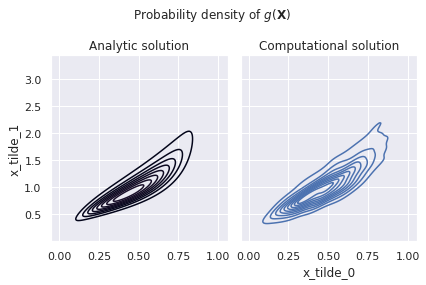

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax = ax.flatten()

ax[0].contour(
    x_tilde[:, 0],
    x_tilde[:, 1],
    (
        inv_det_jacobian_transform(pre_x_tilde[:, 0], pre_x_tilde[:, 1])
        * probability_density(pre_x_tilde[:, 0], pre_x_tilde[:, 1])
    ).T,
    levels=np.linspace(0.4, 80, 100),
)
sns.kdeplot(
    data=data,
    x="x_tilde_0",
    y="x_tilde_1",
    ax=ax[1],
)
ax[0].set_title("Analytic solution")
ax[1].set_title("Computational solution")
ax[0].set_ylabel("x_tilde_1")
fig.suptitle(r"Probability density of $g(\mathbf{X})$")
fig.tight_layout()
fig.savefig("comparison.png");